# Выбор локации для нефтяной скважины


>[Выбор локации для нефтяной скважины](#scrollTo=PjFKhFNJElm0)

>>>[Описание проекта](#scrollTo=MWOvQyM4Elm1)

>>>[Описание данных](#scrollTo=MWOvQyM4Elm1)

>>[Загрузка и подготовка данных](#scrollTo=p0-aylksElm1)

>>>[Импорт библиотек](#scrollTo=p0-aylksElm1)

>>>[Загрузка данных и беглый осмотр](#scrollTo=s2gbXPBfElm2)

>>>[Исследовательский анализ данных](#scrollTo=9eEw6rQIElm3)

>>>[Проверка на мультиколлинеарность и корреляционный анализ](#scrollTo=l6lCHPpzElm3)

>>>[Вывод по шагу 1](#scrollTo=vbj8xANGElm3)

>>[Обучение и проверка модели](#scrollTo=QKVzyHa9Elm4)

>>>[Первый регион](#scrollTo=qp_tzXPUElm4)

>>>[Второй регион](#scrollTo=SL4ArkKQElm4)

>>>[Третий регион](#scrollTo=g7G9ANGEElm4)

>>>[Вывод по шагу 2](#scrollTo=wfziPrTvElm5)

>>[Подготовка к расчету прибыли](#scrollTo=Z73T1W3WElm5)

>>>[Вывод по шагу 3](#scrollTo=MvK5gtgnElm8)

>>[Расчет прибыли и рисков](#scrollTo=MvK5gtgnElm8)

>>>[Вывод по шагу 4](#scrollTo=1ZI2NhlVElm9)

>>[Общий вывод](#scrollTo=1ZI2NhlVElm9)



### Описание проекта

Проект выполняется для добывающей компании «ГлавРосГосНефть». Цель – выбор места для бурения новой скважины из трех вариантов.

Чтобы локация была выбрана для бурения, оценка суммарной прибыли, которую она принесет компании, должна быть наибольшей. Для оценки прибыли с каждой из трех локаций отдельно обучим модель линейной регрессии (остальные — недостаточно предсказуемые) и получим ее предсказания. Отберем наиболее перспективные, по расчетам модели, скважины и определим прибыль, которую с них получила бы компания в действительности.

После этого применим технику *Bootstrap* с 1000 выборок, чтобы найти распределение прибыли. На основании полученной средней прибыли, 95%-й доверительного интервала и риска убытков определим регион для бурения новой скважины.





### Описание данных
Компания предоставила три файла с информацией о пробах нефти в трех регионах соответственно: в каждом 10 000 месторождений, где измерили качество нефти и объем запасов. Эти данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

Файлы с данными:
* `geo_data_0.csv` (первый регион);
* `geo_data_1.csv` (второй регион);
* `geo_data_2.csv` (третий регион).

Признаки, встречающиеся в предоставленных данных

|название столбца|содержащиеся данные|
|:-|:-|
|`id`|уникальный идентификатор скважины|
|`f0`|признак точки|
|`f1`|признак точки|
|`f2`|признак точки|
|`product`|объем запасов в скважине (тыс. баррелей)|

## 1. Загрузка и подготовка данных


### 1.1. Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from sklearn.metrics import mean_squared_error

In [ ]:
def show_num(data, col):
    """
    Принимает:
        - наименование переменной, хранящей датафрейм;
        - наименование столбца с количественными данными в этом датафрейме.
    Возвращает:
        - общее описание данных;
        - гистограмму с наложенным графиком плотности распределения;
        - диаграмму размаха.
    """
    figure, axs = plt.subplots(1, 2, figsize=(15, 8))
    figure.suptitle(col.title())

    sns.histplot(data[col], bins=50, kde=True, ax=axs[0])
    axs[0].set_title('Гистограмма и плотность расределения')

    sns.boxplot(data=data[col], ax=axs[1])
    axs[1].set_title('Диаграмма размаха')

    plt.show()

    display(data[col].describe().to_frame())

In [ ]:
def calculate_profit(product, product_pred, income, expenses, number_in):
    """
    Принимает:
        - объем добытого сырья (в тысячах баррелей);
        - доход, получаемый с одного барреля сырья (в рублях);
        - общие затраты на разработку скважин в регионе (в рублях);
        - количество разрабатываемых скважин;
        - количество рассматриваемых скважин.
    Возвращает величину прибыли.
    """
    product_pred_sorted = product_pred.sort_values(ascending=False)
    selected = product[product_pred_sorted.index][:number_in]
    profit = (selected * 1000 * income).sum() - expenses
    return profit

In [ ]:
sns.set_style('whitegrid')
RANDOM_STATE = 42

### 1.2. Загрузка данных и беглый осмотр

In [ ]:
try:
    data_1 = pd.read_csv('/content/drive/MyDrive/datasets/geo_data_0.csv')
    data_2 = pd.read_csv('/content/drive/MyDrive/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('/content/drive/MyDrive/datasets/geo_data_2.csv')
except:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')

dataframes = [data_1, data_2, data_3]

a = 0
for dataframe in dataframes:
    a += 1
    print(f'Регион {a}')
    print(dataframe.info())
    display(dataframe.head())
    print()
    print()
    print()

Регион 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647





Регион 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305





Регион 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Во всех трех таблицах данные соответствуют описанию, наименовая столбцов идентичны, типы данных адекватны, пропусков нет.

Проверим наличие дубликатов в каждой таблице, а также повторяющихся `id` в разных таблицах.

In [ ]:
print('Дубликаты:')
for dataframe in dataframes:
    print(dataframe['id'].duplicated().sum())

for dataframe in dataframes:
    ids = dataframe.loc[dataframe['id'].duplicated()]['id'].to_list()
    for i in ids:
        print(dataframe.loc[dataframe['id']==i])
    print()
    print()

print('Повторы в разных таблицах:')
display(data_1.merge(data_2, on='id', how='inner'))
display(data_2.merge(data_3, on='id', how='inner'))
display(data_1.merge(data_3, on='id', how='inner'))

Дубликаты:
10
4
4
         id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695
          id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798
          id        f0        f1        f2    product
3389   A5aEY -0.039949  0.156872  0.209861  89.249364
51970  A5aEY -0.180335  0.935548 -2.094773  33.020205
          id        f0        f1        f2    product
1949   QcMuo  0.506563 -0.323775 -2.215583  75.496502
63593  QcMuo  0.635635 -0.473422  0.862670  64.578675
          id        f0        f1        f2     product
64022  74z30  0.741456  0.459229  5.153109  140.771492
66136  74z30  1.084962 -0.312358  6.990771  127.643327
          id        f0        f1        f2     product
42529  AGS9W  1.454747 -0.479651  0.683380  126.370504
69163  AGS9W -0.933795  0.116194 -3.655896   19.230453
 

,id,f0_x,f1_x,f2_x,product_x,f0_y,f1_y,f2_y,product_y
0,Q64YW,0.453692,0.851595,1.483317,137.265232,3.005548,-0.243063,5.000265,134.766305
1,CXJ2r,1.799663,0.152615,2.308270,124.783815,4.595329,-1.967882,4.000767,107.813044
2,Y2udP,1.226808,-0.482702,7.197720,178.864963,12.544203,5.897907,1.007743,26.953261
3,g3RRG,1.256835,-0.594468,2.258115,36.909351,5.884971,-3.853958,5.000735,134.766305
4,mpZhE,1.050752,0.001206,3.015799,102.323401,11.206881,-2.291883,1.003807,26.953261
5,L1Fdm,-0.870625,0.216046,6.551127,99.473405,-3.346138,1.878476,0.004355,3.179103
6,it2OW,-0.649660,0.966137,7.852383,152.939409,-7.472182,-14.802085,4.005783,110.992147
7,gnA83,0.874183,0.658348,4.315275,78.952516,13.842436,-12.362831,4.003258,107.813044
8,Mp3uM,0.233182,0.999516,1.626957,109.425501,6.109864,-6.680806,4.995256,134.766305
9,pGQRI,0.042350,-0.052613,2.241901,168.331029,-5.171681,-0.546409,3.002864,84.038886


,id,f0_x,f1_x,f2_x,product_x,f0_y,f1_y,f2_y,product_y
0,TAqwC,-13.045712,-13.056006,0.007640,3.179103,-0.176382,-0.503558,1.877303,38.618695
1,uMqiK,2.734183,-3.102346,-0.002654,0.000000,-1.772509,0.152085,-0.422541,119.682928
2,D8TNs,-0.646266,3.667055,1.006161,30.132364,0.280382,0.061393,4.887870,114.943876
3,g2I86,17.818406,2.946716,0.991640,26.953261,-1.616730,1.110380,4.226968,107.940639


,id,f0_x,f1_x,f2_x,product_x,f0_y,f1_y,f2_y,product_y
0,wqgPo,2.009877,-0.119927,5.254332,72.798085,0.052461,1.424025,0.085541,10.686576
1,kpKGs,1.984545,0.356201,-0.876743,53.006141,0.391595,0.520890,0.935081,91.558464
2,scFN4,1.209207,-0.491543,0.871066,82.239907,2.198203,0.733283,10.562272,153.719681
3,i2csb,1.876060,0.130102,3.916158,178.191619,0.395736,-1.039466,3.262824,136.079194
4,Suyut,1.034755,0.211378,5.166985,134.183249,0.730034,0.998910,0.673342,51.978338
5,uSye4,1.452571,-0.452693,-1.800189,79.717634,-0.066172,2.543996,-0.054049,141.345070
6,5ssQt,-1.005117,0.268726,-0.407822,53.206029,-0.651825,0.782415,2.690636,120.108761
7,tgOl6,1.242237,-0.545994,-1.070228,52.566338,-6.077439,-1.366449,1.858951,153.001240
8,2tyMi,0.576679,-0.411140,-3.725859,69.292672,-1.789602,-1.359044,-4.840745,145.901447
9,TXPOv,-0.614415,0.669327,4.392560,111.029432,-1.714714,0.545975,6.907380,109.685043


Каждая скважина с повторяющимся `id` обладает собственным уникальным набором характеристик. Оставим все эти строки.

Похоже, что для присвоения скважинам `id` использовали генератор случайных последовательностей символов, и произошли повторы.


### 1.3. Исследовательский анализ данных



Регион 1


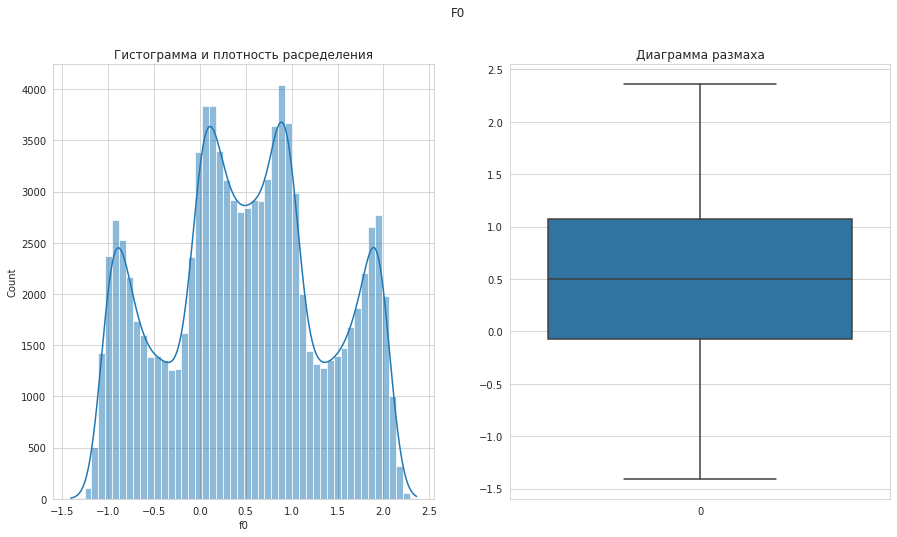

,f0
count,100000.000000
mean,0.500419
std,0.871832
min,-1.408605
25%,-0.072580
50%,0.502360
75%,1.073581
max,2.362331


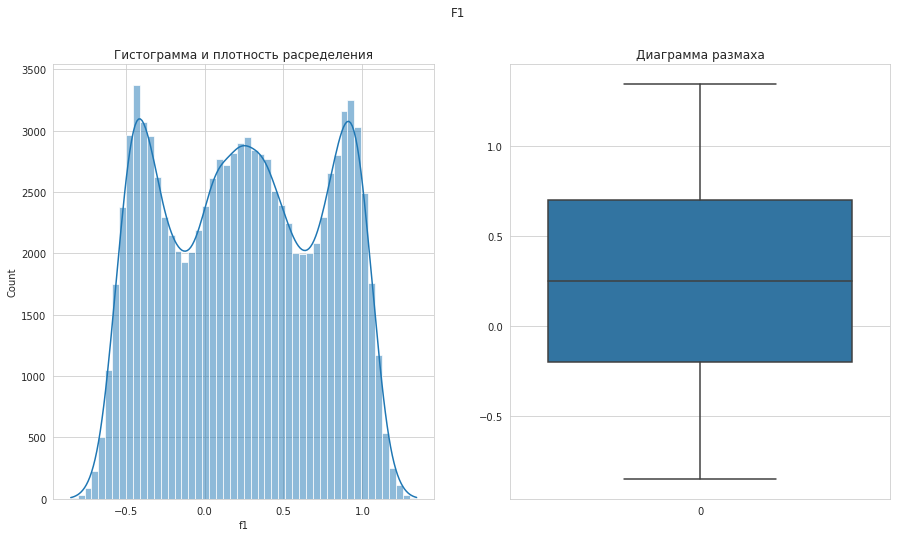

,f1
count,100000.000000
mean,0.250143
std,0.504433
min,-0.848218
25%,-0.200881
50%,0.250252
75%,0.700646
max,1.343769


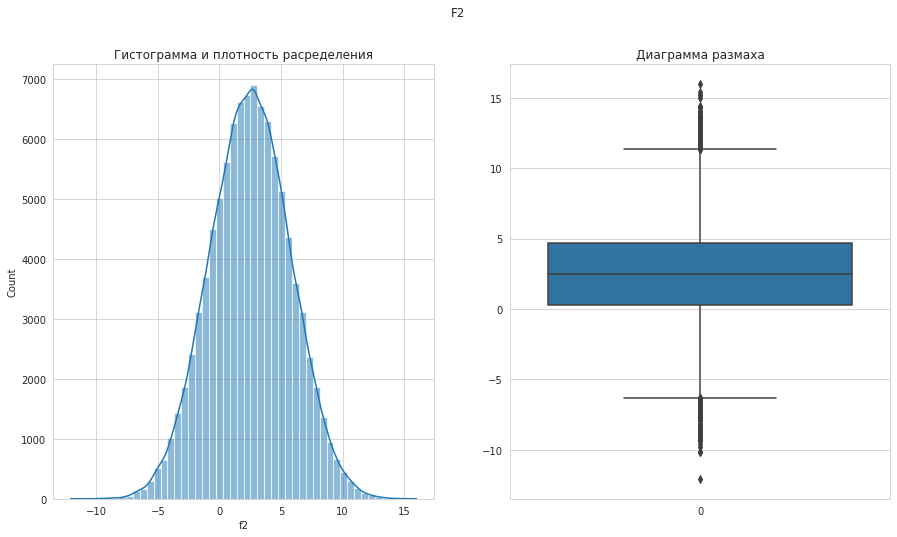

,f2
count,100000.000000
mean,2.502647
std,3.248248
min,-12.088328
25%,0.287748
50%,2.515969
75%,4.715088
max,16.003790


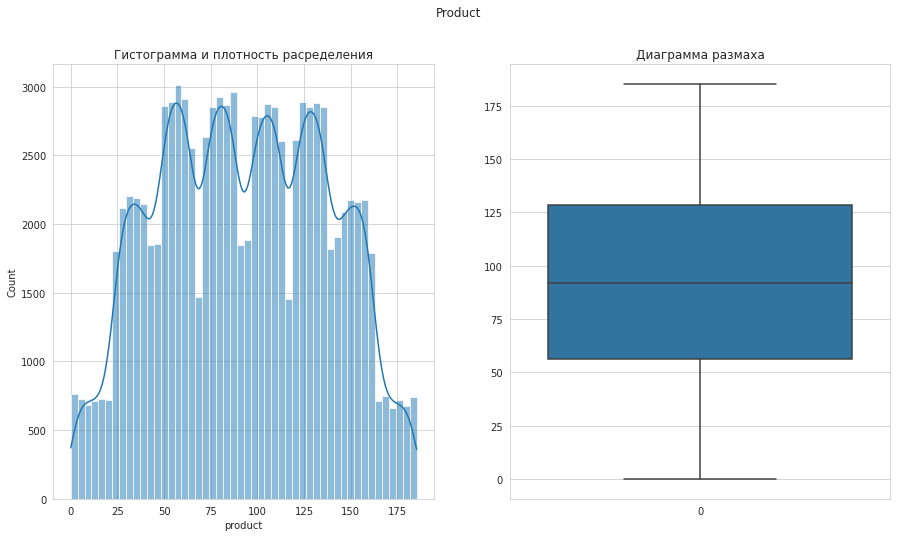

,product
count,100000.000000
mean,92.500000
std,44.288691
min,0.000000
25%,56.497507
50%,91.849972
75%,128.564089
max,185.364347




Регион 2


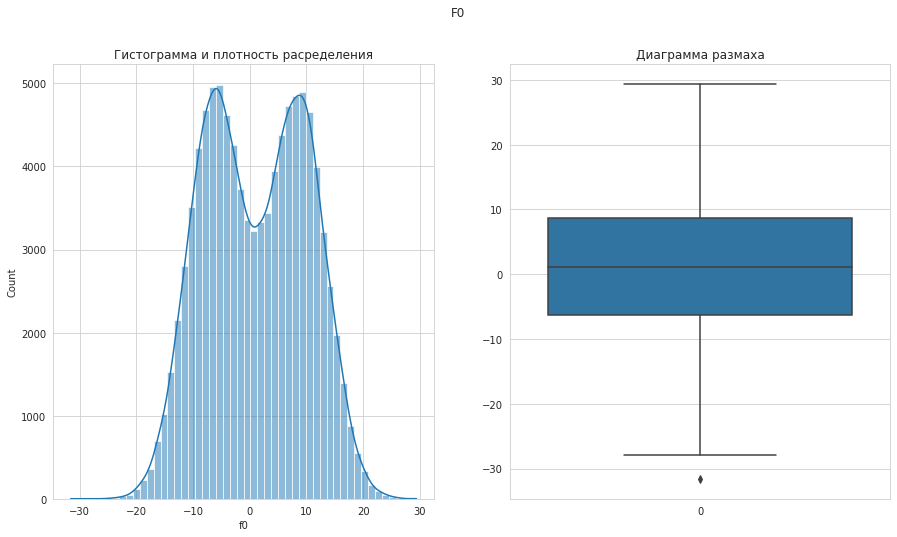

,f0
count,100000.000000
mean,1.141296
std,8.965932
min,-31.609576
25%,-6.298551
50%,1.153055
75%,8.621015
max,29.421755


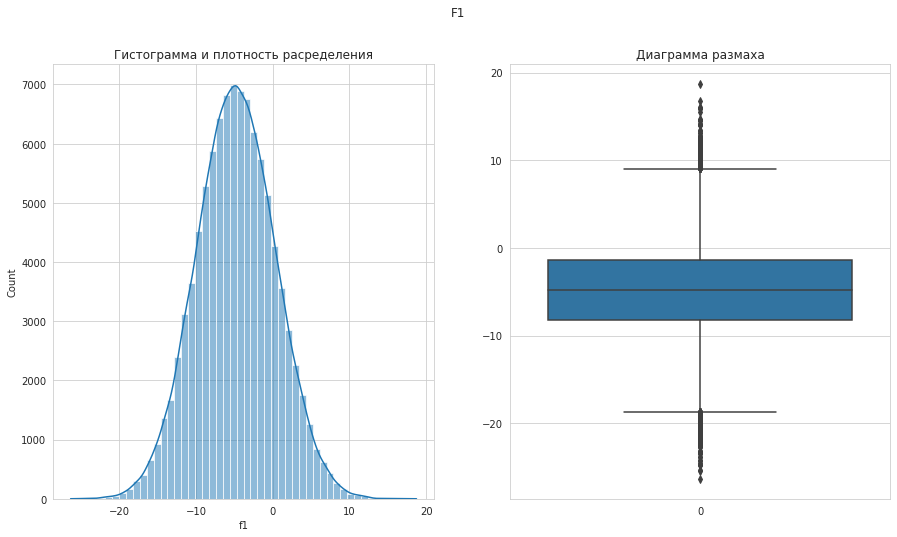

,f1
count,100000.000000
mean,-4.796579
std,5.119872
min,-26.358598
25%,-8.267985
50%,-4.813172
75%,-1.332816
max,18.734063


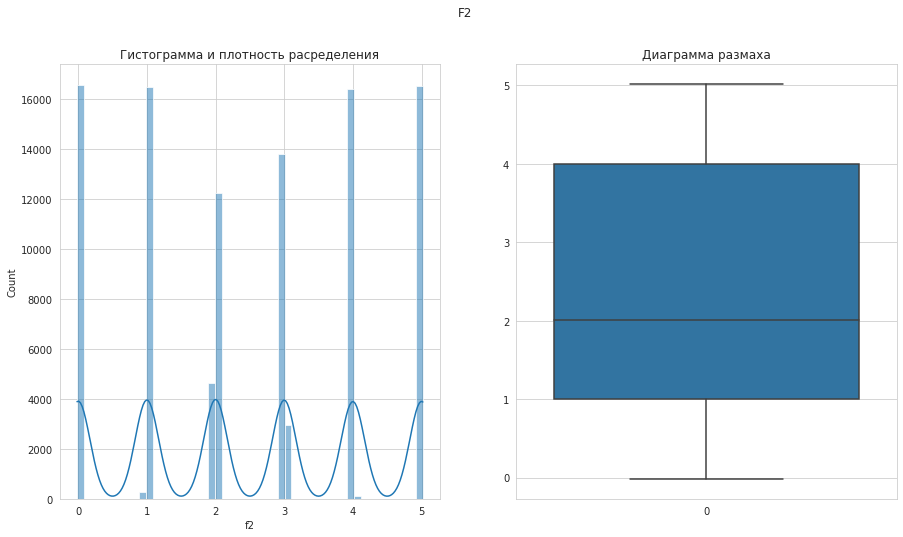

,f2
count,100000.000000
mean,2.494541
std,1.703572
min,-0.018144
25%,1.000021
50%,2.011479
75%,3.999904
max,5.019721


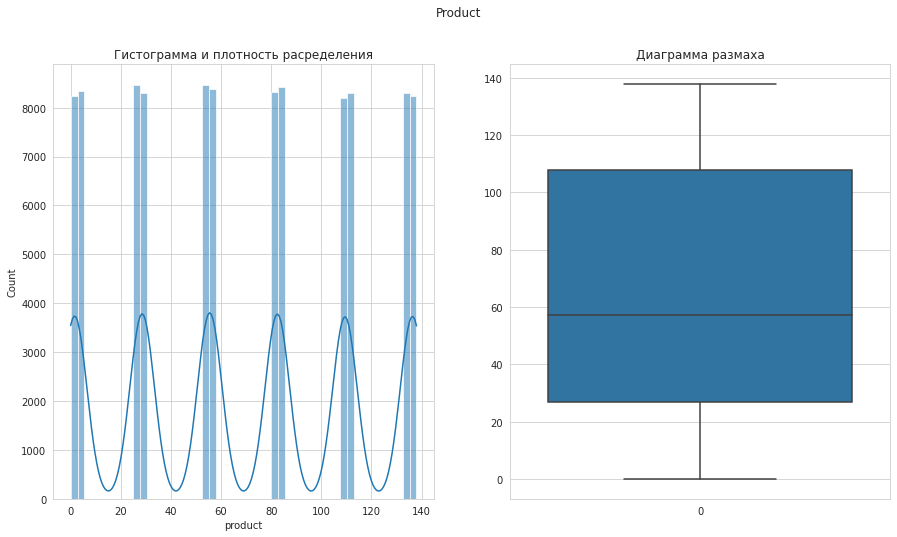

,product
count,100000.000000
mean,68.825000
std,45.944423
min,0.000000
25%,26.953261
50%,57.085625
75%,107.813044
max,137.945408




Регион 3


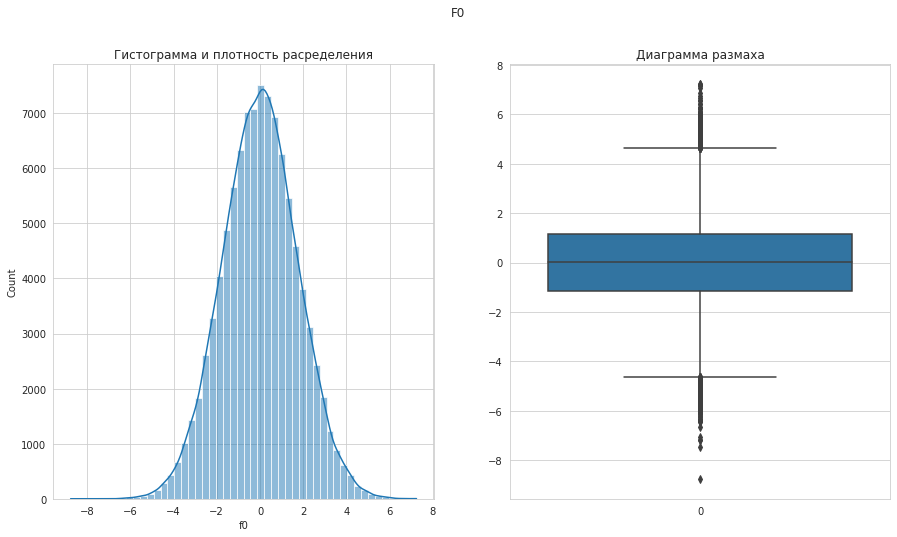

,f0
count,100000.000000
mean,0.002023
std,1.732045
min,-8.760004
25%,-1.162288
50%,0.009424
75%,1.158535
max,7.238262


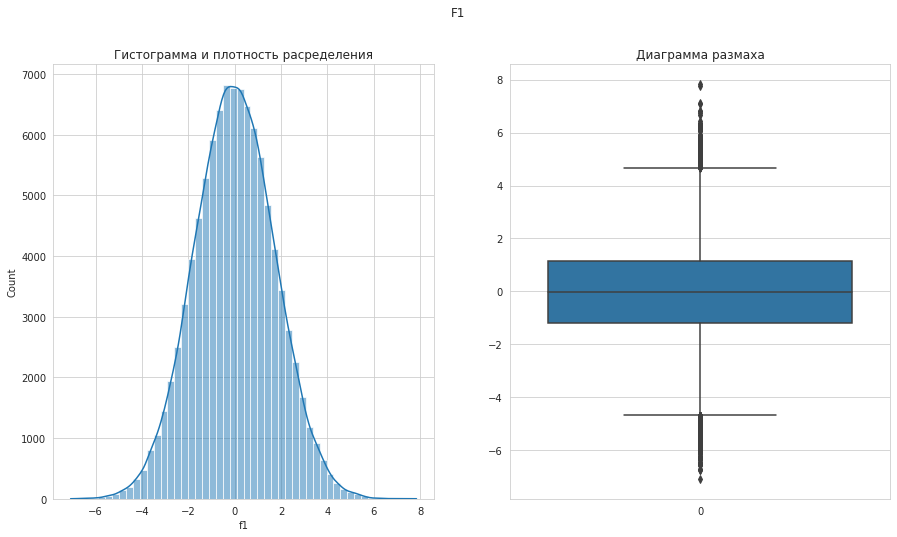

,f1
count,100000.000000
mean,-0.002081
std,1.730417
min,-7.084020
25%,-1.174820
50%,-0.009482
75%,1.163678
max,7.844801


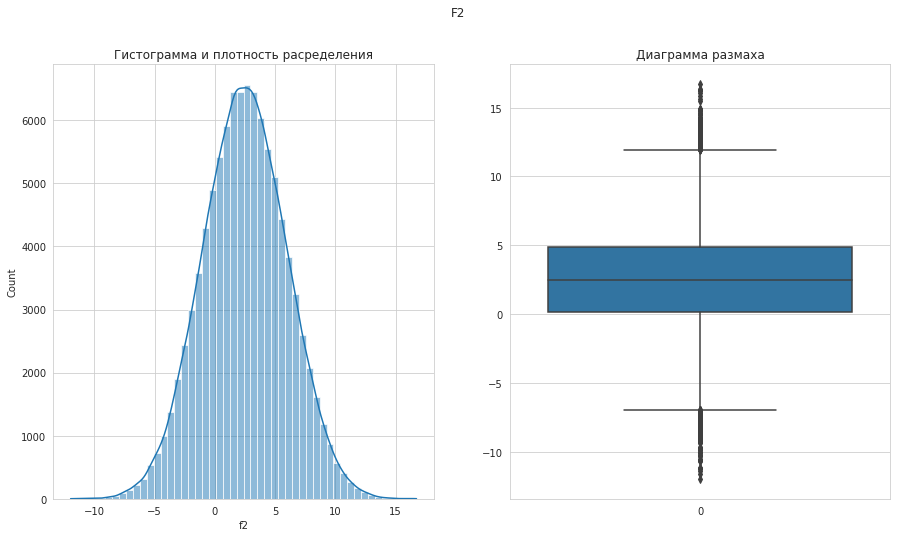

,f2
count,100000.000000
mean,2.495128
std,3.473445
min,-11.970335
25%,0.130359
50%,2.484236
75%,4.858794
max,16.739402


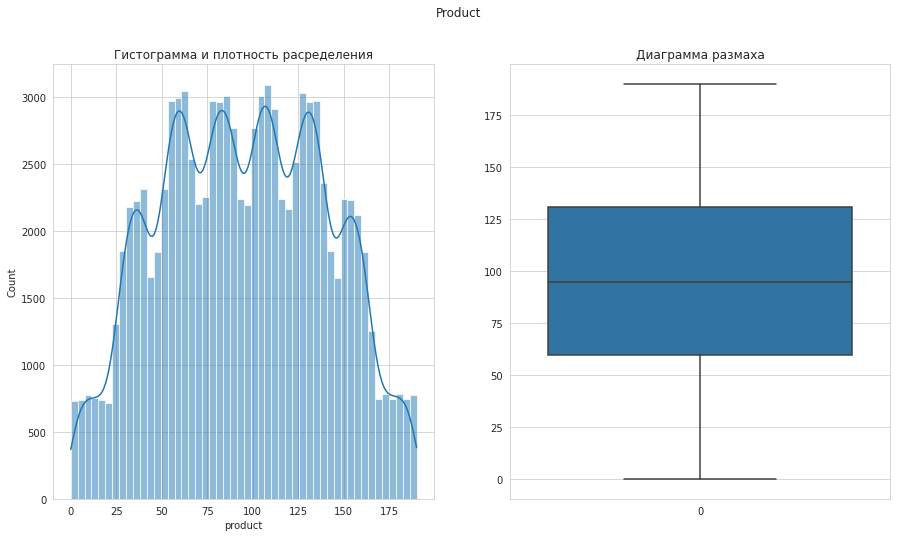

,product
count,100000.000000
mean,95.000000
std,44.749921
min,0.000000
25%,59.450441
50%,94.925613
75%,130.595027
max,190.029838


In [ ]:
columns = ['f0', 'f1', 'f2', 'product']
a = 0
for dataframe in dataframes:
    a += 1
    print(f'Регион {a}')
    for column in columns:
        show_num(dataframe, column)
    print()
    print()

**Предварительные выводы:**

Значения признаков распределены по-разному в разных районах. Поэтому необходимо обучить свою модель для каждого района.

Нормальными можно назвать только некоторые распределения. В данных не очень много выбросов. Аномальные значения можно было бы выявить только для столбца `product`, и их нет ни в одной из таблиц.

Поскольку мы будем строить линейные модели, необходимо провести проверку на мультиколлинеарность.



### Проверка на мультиколлинеарность и корреляционный анализ

Для проверки воспользуемся коэффициентом корреляции Спирмана.

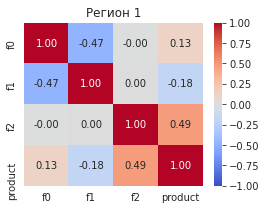

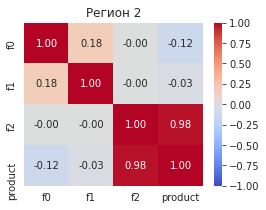

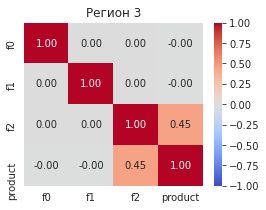

In [ ]:
a = 0
for dataframe in dataframes:
    a += 1
    corr_matrix = dataframe[columns].corr(method='spearman')
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0
    )
    plt.title(f'Регион {a}')
    plt.show()

**Предварительные выводы:**

Сильных связей между входными признаками нет ни в одном из трех регионов.

При этом:
* в первом регионе целевой признак имеет умеренную взаимосвязь с `f2` и очень слабую – с остальными входными признаками;
* во втором регионе целевой признак имеет очень сильную взаимосвязь с `f2`, очень слабую – с `f0` и практически отсутствующую – с `f1`;
* в третьем регионе целевой признак имеет умеренную взаимосвязь с `f2` и практически отсутствующую – с остальными входными признаками.

### Вывод по шагу 1

Во всех трех таблицах данные соответствуют описанию, наименования столбцов идентичны, типы данных адекватны, пропусков нет.

Обнаружено небольшое число повторяющихся `id` как в пределах каждой таблицы, так и в разных таблицах. Строки с ними оставлены, поскольку каждая скважина с повторяющимся `id` имеет собственные уникальные значения признаков. Похоже, что для присвоения скважинам `id` использовали генератор случайных последовательностей символов, и произошли повторы.

Значения признаков распределены по-разному в разных районах. Поэтому необходимо обучить свою модель для каждого района.

Нормальными можно назвать только некоторые распределения. В данных не очень много выбросов. Аномальные значения можно было бы выявить только для столбца product, и их нет ни в одной из таблиц.

Сильных связей между входными признаками нет ни в одном из трех регионов.

При этом целевой признак имеет следующие взаимосвязи с входными:

* в первом регионе:
  * умеренную – с `f2`;
  * очень слабую – с остальными входными признаками;
* во втором регионе:
  * очень сильную  – с `f2`;
  * очень слабую – с `f0`;
  * практически отсутствующую – с `f1`;
* в третьем регионе:
  * умеренную – с `f2`;
  * практически отсутствующую – с остальными входными признаками.




## 2. Обучение и проверка модели

Разобьем данные о каждом регионе на тренировочную и валидационную выборки в соотношении 75:25.

Проведем масштабирование входных признаков и обучение моделей в пайплайнах. Лучшую модель (отличаться будут только методы масштабирования) для каждого региона выберем по метрике `RMSE` при помощи `GridSearchCV`, поскольку не придется перебирать большое множество вариантов: мы уже определили, что будем использовать линейную регрессию.

In [ ]:
features = ['f0', 'f1', 'f2']

data_preprocessor = ColumnTransformer(
    [
        ('preprocessing', StandardScaler(), features)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LinearRegression())]
)

params = [{
        'models': [LinearRegression()],
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}]

### 2.1. Первый регион

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    data_1.drop(
        ['id', 'product'],
        axis=1
    ),
    data_1['product'],
    test_size = 0.25,
    random_state = RANDOM_STATE
)

search_1 = GridSearchCV(
        pipe_final,
        params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
)
search_1.fit(X_train_1, y_train_1)

print('Первый регион')
print('Лучшая модель и ее параметры:\n', search_1.best_estimator_)
print()
print ('Метрика RMSE на кроссвалидации:', search_1.best_score_ * -1)

Первый регион
Лучшая модель и ее параметры:
 Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models', LinearRegression())])

Метрика RMSE на кроссвалидации: 37.67200536313506


Метрика RMSE на валидационной выборке: 37.75660035026169
Средний запас предсказанного сырья: 92.51821088393348
Средний запас реального сырья: 92.50000000000001


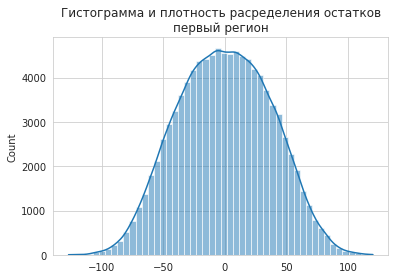

In [ ]:
best_model_1 = search_1.best_estimator_.named_steps['models']
best_preprocessor_1 = search_1.best_estimator_.named_steps['preprocessor']

y_pred_1 = best_model_1.predict(best_preprocessor_1.transform(X_test_1))
print ('Метрика RMSE на валидационной выборке:',
       mean_squared_error(y_test_1, y_pred_1, squared=False))

data_1['product_pred'] = best_model_1.predict(best_preprocessor_1.transform(data_1[features]))
print('Средний запас предсказанного сырья:', data_1['product_pred'].mean())
print('Средний запас реального сырья:', data_1['product'].mean())

sns.histplot(data_1['product_pred'] - data_1['product'], bins=50, kde=True)
plt.title('Гистограмма и плотность расределения остатков\nпервый регион')
plt.show()

Модель показала сходные результаты на тестовой и валидационной выборках, значит, не произошло утечки данных и переобучения или недообучения. Остатки модели нормально распределены со средним, близким к нулю. Среднее предсказанных значений очень близко к среднему реальных запасов.

Однако среднеквадратичная ошибка очень велика. Возможно, при разведке этого региона следует уделять внимание также другим признакам.



### 2.2. Второй регион

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    data_2.drop(
        ['id', 'product'],
        axis=1
    ),
    data_2['product'],
    test_size = 0.25,
    random_state = RANDOM_STATE
)


search_2 = GridSearchCV(
        pipe_final,
        params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
)
search_2.fit(X_train_2, y_train_2)

print('Второй регион')
print('Лучшая модель и ее параметры:\n', search_2.best_estimator_)
print()
print ('Метрика RMSE на кроссвалидации:', search_2.best_score_ * -1)

Второй регион
Лучшая модель и ее параметры:
 Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models', LinearRegression())])

Метрика RMSE на кроссвалидации: 0.8904559629285671


Метрика RMSE на валидационной выборке: 0.8902801001028846
Средний запас предсказанного сырья: 68.82187432297754
Средний запас реального сырья: 68.82500000000002


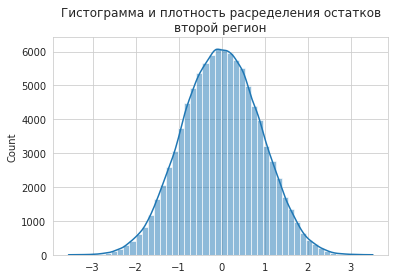

In [ ]:
best_model_2 = search_2.best_estimator_.named_steps['models']
best_preprocessor_2 = search_2.best_estimator_.named_steps['preprocessor']

y_pred_2 = best_model_2.predict(best_preprocessor_2.transform(X_test_2))
print('Метрика RMSE на валидационной выборке:',
       mean_squared_error(y_test_2, y_pred_2, squared=False))

data_2['product_pred'] = best_model_2.predict(best_preprocessor_2.transform(data_2[features]))
print('Средний запас предсказанного сырья:', data_2['product_pred'].mean())
print('Средний запас реального сырья:', data_2['product'].mean())

sns.histplot(data_2['product_pred'] - data_2['product'], bins=50, kde=True)
plt.title('Гистограмма и плотность расределения остатков\nвторой регион')
plt.show()

Модель показала сходные результаты на тестовой и валидационной выборках, значит, не произошло утечки данных и переобучения или недообучения. Остатки модели нормально распределены со средним, близким к нулю. Среднее предсказанных значений очень близко к среднему реальных запасов.

Среднеквадратичная ошибка очень мала. Это должно объясняться очень сильной корреляцией между целевым и одним из входных признаков в этом регионе.  



### 2.3. Третий регион

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    data_3.drop(
        ['id', 'product'],
        axis=1
    ),
    data_3['product'],
    test_size = 0.25,
    random_state = RANDOM_STATE
)


search_3 = GridSearchCV(
        pipe_final,
        params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
)
search_3.fit(X_train_3, y_train_3)

print('Третий регион')
print('Лучшая модель и ее параметры:\n', search_3.best_estimator_)
print()
print ('Метрика RMSE на кроссвалидации:', search_3.best_score_ * -1)

Третий регион
Лучшая модель и ее параметры:
 Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models', LinearRegression())])

Метрика RMSE на кроссвалидации: 40.02698159997838


Метрика RMSE на валидационной выборке: 40.145872311342174
Средний запас предсказанного сырья: 94.90500620148497
Средний запас реального сырья: 95.00000000000004


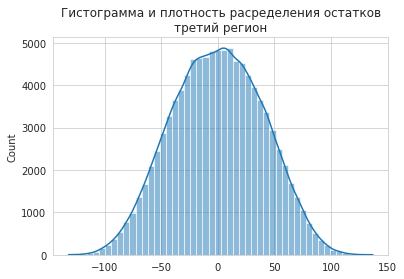

In [ ]:
best_model_3 = search_3.best_estimator_.named_steps['models']
best_preprocessor_3 = search_3.best_estimator_.named_steps['preprocessor']

y_pred_3 = best_model_3.predict(best_preprocessor_3.transform(X_test_3))
print ('Метрика RMSE на валидационной выборке:',
       mean_squared_error(y_test_3, y_pred_3, squared=False))

data_3['product_pred'] = best_model_3.predict(best_preprocessor_3.transform(data_3[features]))
print('Средний запас предсказанного сырья:', data_3['product_pred'].mean())
print('Средний запас реального сырья:', data_3['product'].mean())

sns.histplot(data_3['product_pred'] - data_3['product'], bins=50, kde=True)
plt.title('Гистограмма и плотность расределения остатков\nтретий регион')
plt.show()

Модель показала сходные результаты на тестовой и валидационной выборках. Остатки модели нормально распределены со средним, близким к нулю. Среднее предсказанных значений очень близко к среднему реальных запасов.

Однако среднеквадратичная ошибка очень велика. Возможно, при разведке этого региона следует уделять внимание также другим признакам.



### Вывод по шагу 2

Модели показывают стабильные результаты на тестовой и валидационной выборках, значит, не произошло утечки данных и переобучения или недообучения. Их остатки нормально распределены со средним, близким к нулю. Среднее предсказанных значений очень близко к среднему реальных запасов.

Однако достаточно точно удается предсказывать запасы скважин только во втором регионе. Прогнозы для первого и третьего очень неточны. Возможно, при разведке этих регионов следует уделять внимание также другим признакам или иначе подходить к моделированию.

## 3. Подготовка к расчету прибыли

Рассчитаем, какой объем сырья будет достаточным для безубыточной разработки новой скважины.

In [ ]:
INCOME = 450 # доход, получаемый с одного барреля сырья (в рублях)
EXPENSES = 10**10 # затраты на разработку скважин в регионе (в рублях)
NUMBER_IN = 200 # количество разрабатываемых скважин
NUMBER_ALL = 500 # количество исследуемых скважин

needed_volume = EXPENSES / INCOME / 1000 / NUMBER_IN

print('Необходимый средний объем сырья для безубыточной разработки новой скважины:', needed_volume)

Необходимый средний объем сырья для безубыточной разработки новой скважины: 111.11111111111111



<div class="alert alert-block alert-info">
    
<b>Совет:</b> Константы принято записывать в ВЕРХНЕМ РЕГИСТРЕ =) Читем здесь https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#section-29
    

<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно, с выводом согласен  
</div>


### Вывод по шагу 3

Таким образом, компании необходимо тщательно выбрать наиболее богатые месторождения для разработки, чтобы избежать убытка, поскольку нужный для покрытия расходов средний объем больше среднего объема запасов в каждом из регионов.



## 4. Расчет прибыли и рисков

Оценим риски для каждого региона при помощи *Bootstrap*, применяя собственную функцию `calculate_profit`. Найдем 95%-е доверительные интервалы для средней прибыли. Отберем только те регионы, в которых 0.025-квантиль прибыли не будет отрицательным. Если таких окажется больше одного, выберем из них регион с наибольшей средней прибылью.

Для удобства представим результаты расчетов в форме таблицы.

In [ ]:
state = np.random.RandomState(12345)

profit_means = []
low_quantilies = []
up_quantilies = []
loss_probabilities = []

for dataframe in dataframes:
    product_pred = dataframe['product_pred']
    product = dataframe['product']
    values = []
    values_mean = []

    for i in range(1000):
        product_subsample = product.sample(n=number_all, replace=True, random_state=state)
        product_pred_subsample = product_pred[product_subsample.index]
        values.append(calculate_profit(
            product_subsample,
            product_pred_subsample,
            income,
            expenses,
            number_in
        ))

    values = pd.Series(values)
    profit_means.append(round(values.mean()))
    low_quantilies.append(round(values.quantile(q=0.025)))
    up_quantilies.append(round(values.quantile(q=0.975)))

    values_sorted = values.sort_values(ascending=False).reset_index()
    for i in range(1000):
        if values_sorted[0][i] < 0:
            loss_probabilities.append(1 - (i / 1000))
            break

df_profit = pd.DataFrame(
    [profit_means, low_quantilies, up_quantilies, loss_probabilities],
    columns=[
        'первый_регион',
        'второй_регион',
        'третий_регион'
    ],
    index=[
        'средняя_прибыль',
        'нижняя_граница_доверительного_интервала',
        'верхняя_граница_доверительного_интервала',
        'вероятность_убытка'
    ]
)
display(df_profit.style.format('{:.3f}'))

,первый_регион,второй_регион,третий_регион
средняя_прибыль,430604329.000,450073113.000,391446565.000
нижняя_граница_доверительного_интервала,-69135045.000,44596630.000,-147332988.000
верхняя_граница_доверительного_интервала,984211546.000,830796302.000,877712495.000
вероятность_убытка,0.051,0.010,0.085


### Вывод по шагу 4

Только во втором регионе вероятность убытка можно оценить меньше чем 2.5%. Это лучшая локация для разработки скважин.
Привлекательность второго региона связана с высокой предсказуемостью запасов по сравнению с двумя другими регионами.



## Общий вывод

1. Загрузили и исследовали данные. Обнаружили:
* Все предоставленные компанией данные соответствуют описанию, наименовая столбцов идентичны, типы данных адекватны, пропусков нет, полных дубликатов тоже нет (повторения `id` сочтены случайными).
* Нормальными можно назвать только некоторые распределения. В данных не очень много выбросов, аномальные значения не выявлены.
* Предобработка не потребовалась.
* Значения признаков распределены по-разному в разных районах. Поэтому в шаге 2 потребовалось обучить свою модель для каждого района.
* Сильных взаимосвязей между входными признаками нет ни в одном из трех регионов.
* Целевой признак имеет следующие взаимосвязи с входными:

  * в первом регионе:
    * умеренную – с `f2`;
    * очень слабую – с остальными входными признаками;
  * во втором регионе:
    * очень сильную  – с `f2`;
    * очень слабую – с `f0`;
    * практически отсутствующую – с `f1`;
  * в третьем регионе:
    * умеренную – с `f2`;
    * практически отсутствующую – с остальными входными признаками.
  
2. Обучили три модели линейной регрессии:
* Все три показали стабильные результаты на тестовой и валидационной выборках, значит, не произошло утечки данных и переобучения или недообучения.
* Их остатки нормально распределены со средним, близким к нулю. Среднее предсказанных значений очень близко к среднему реальных запасов.
* Достаточно точно удалось предсказывать запасы скважин только во втором регионе. Прогнозы для первого и третьего очень неточны.  

3. Расчитали, какой средний запас должны иметь скважины, чтобы разработка региона не оказалась убыточной. Он оказался больше среднего объема запасов в каждом из регионов. Значит, необходимо тщательно выбрать наиболее богатые месторождения для разработки.

4. Оценили вероятность убытков и среднюю прибыль в каждом из регионов. Только во втором регионе вероятность убытка можно оценить меньше чем 2.5%.
5. Рекомендации для компании «ГлавРосГосНефть»:
* Второй регион является лучшей локацией для разработки скважин. Его привлекательность связана с высокой предсказуемостью запасов по сравнению с двумя другими регионами, более богатыми на первый взгляд.
* Возможно, при разведке первого и третьего регионов следует найти новые признаки или пересмотреть формат представления уже имеющихся данных, чтобы повысить точность прогнозов и снизить риски. Это поможет существенно увеличить потенциальную прибыль.